# Stress Testing Common XAI Algos in the Literature

In [200]:
import pandas as pd
import numpy as np
import lime
import os
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

sns.set()

In [201]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## Case #1: Data Generated from a Common Cause Structure with Independent Vars

The purpose of this test is to understand how current algorithms of the literature such as LIME and SHAP can represent feature in important in situations where data is generated from a common cause structure. We also added an independent variable to understand if this variable will be considered as relevant to the algorithm. We will train an XGboost classifier with data generated from the model below and run XAI algortihms to understand the computed feature importance.

<img src="https://raw.githubusercontent.com/catarina-moreira/XAI_Algos/0de91f13187c7a136676e049804c6b6e4de3ff44/networks/common_cause.png" />

In [410]:
# load the common cause data
data_common_cause = pd.read_csv(os.path.join("gen_data", "logistic_reg.dat"))
data_common_cause.head()

,X1,X2,X3,Y
0,0.783979,0.746027,0.951821,1
1,0.977481,0.918871,0.476702,1
2,0.301225,0.932348,0.425682,0
3,0.055496,1.000000,0.611392,1
4,0.514307,0.583843,0.083074,0


In [467]:
class_var = "Y"
features = data_common_cause.columns.to_list()
features.remove(class_var)

X = data_common_cause[features]
y = data_common_cause[class_var]

Y = pd.DataFrame([], columns=["Y_0", "Y_1"])
for indx in range(len(y.values)):
  if y.values[indx] == 0:
    Y.loc[indx, :] = [1,0]
  else:
    Y.loc[indx, :] = [0,1]

Y = Y.astype('float32')

In [469]:
# for NN
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.3, random_state=515)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=515)

### Training a Neural Network Classifier


In [458]:
act_fn = "tanh"
nn = tf.keras.Sequential([
  layers.Dense(7, activation=act_fn, input_shape=(X_train.shape[-1],) ),
  #layers.Dense(7, activation='relu'),
  layers.Dense(5, activation=act_fn),
  layers.Dense(3, activation=act_fn),
  layers.Dense(2, activation="softmax")
])

learning_rate = 0.001
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
           loss="binary_crossentropy",
            metrics=["accuracy"])

batch_size = 32
history = nn.fit(X_train, y_train, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val),
          verbose=1)

Epoch 1/50
110/110 [==============================] - 1s 5ms/step - loss: 0.6922 - accuracy: 0.5299 - val_loss: 0.6768 - val_accuracy: 0.6187
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.7176 - val_loss: 0.6180 - val_accuracy: 0.8013
Epoch 3/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5584 - accuracy: 0.8285 - val_loss: 0.5041 - val_accuracy: 0.8493
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 0.4404 - accuracy: 0.8640 - val_loss: 0.3997 - val_accuracy: 0.8653
Epoch 5/50
110/110 [==============================] - 1s 7ms/step - loss: 0.3535 - accuracy: 0.8780 - val_loss: 0.3342 - val_accuracy: 0.8760
Epoch 6/50
110/110 [==============================] - 1s 7ms/step - loss: 0.3054 - accuracy: 0.8763 - val_loss: 0.2992 - val_accuracy: 0.8867
Epoch 7/50
110/110 [==============================] - 1s 6ms/step - loss: 0.2802 - accuracy: 0.8748 - val_loss: 0.2803 - val_accuracy: 0.8840
Epoch 

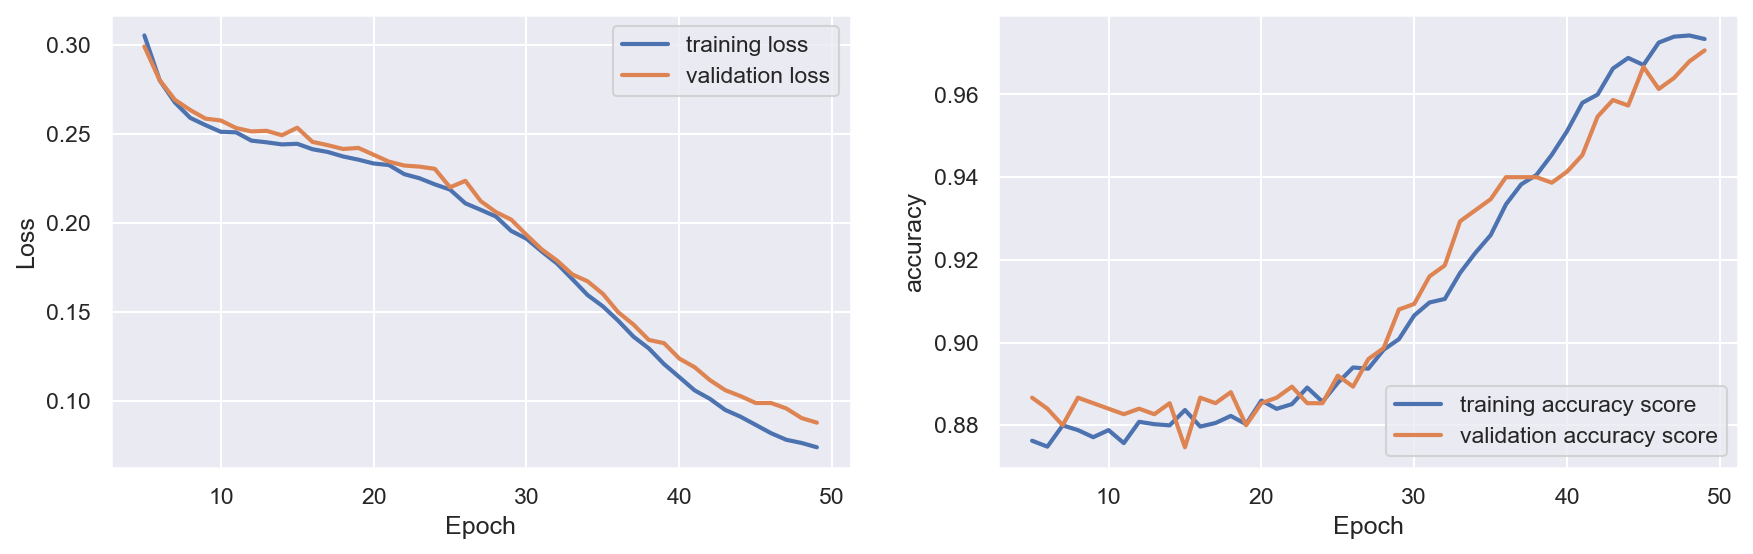

In [459]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"accuracy"], lw=2, label='training accuracy score')
plt.plot(logs.loc[5:,"val_accuracy"], lw=2, label='validation accuracy score')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()

### Training an XGBoost Classifier

In [460]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [471]:
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [486]:
xgb = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, 
                    min_child_weight = 10, subsample = 0.8)

xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
preds = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, preds)


print("Accuracy: %3.2f" % (acc_xgb))


[0]	validation_0-logloss:0.68404	validation_1-logloss:0.68447
[1]	validation_0-logloss:0.67516	validation_1-logloss:0.67585
[2]	validation_0-logloss:0.66677	validation_1-logloss:0.66766
[3]	validation_0-logloss:0.65817	validation_1-logloss:0.65939
[4]	validation_0-logloss:0.64971	validation_1-logloss:0.65136
[5]	validation_0-logloss:0.64141	validation_1-logloss:0.64341
[6]	validation_0-logloss:0.63322	validation_1-logloss:0.63566
[7]	validation_0-logloss:0.62541	validation_1-logloss:0.62815
[8]	validation_0-logloss:0.61766	validation_1-logloss:0.62077
[9]	validation_0-logloss:0.61005	validation_1-logloss:0.61340
[10]	validation_0-logloss:0.60247	validation_1-logloss:0.60604
[11]	validation_0-logloss:0.59506	validation_1-logloss:0.59899
[12]	validation_0-logloss:0.58767	validation_1-logloss:0.59190
[13]	validation_0-logloss:0.58041	validation_1-logloss:0.58492
[14]	validation_0-logloss:0.57334	validation_1-logloss:0.57813
[15]	validation_0-logloss:0.56644	validation_1-logloss:0.57151
[1

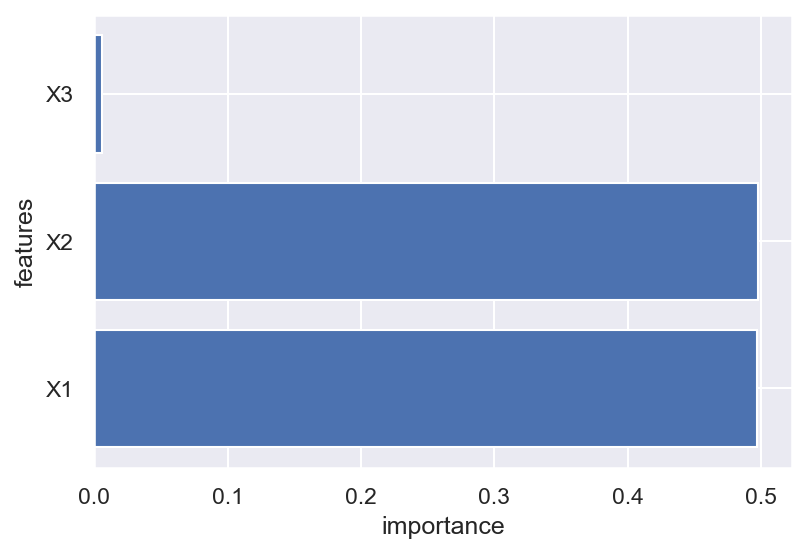

In [487]:
def plot_feature_importances(model):
      n_features = X.shape[1]
      plt.barh(range(n_features),model.feature_importances_,align="center")
      plt.yticks(np.arange(n_features),X)
      plt.xlabel("importance")
      plt.ylabel("features")
      plt.show

plot_feature_importances(xgb)
   

### Generating Explanations for XGBoost

In [488]:
from  lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer

Prediction: 1


c:\Users\cmore\anaconda3\lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


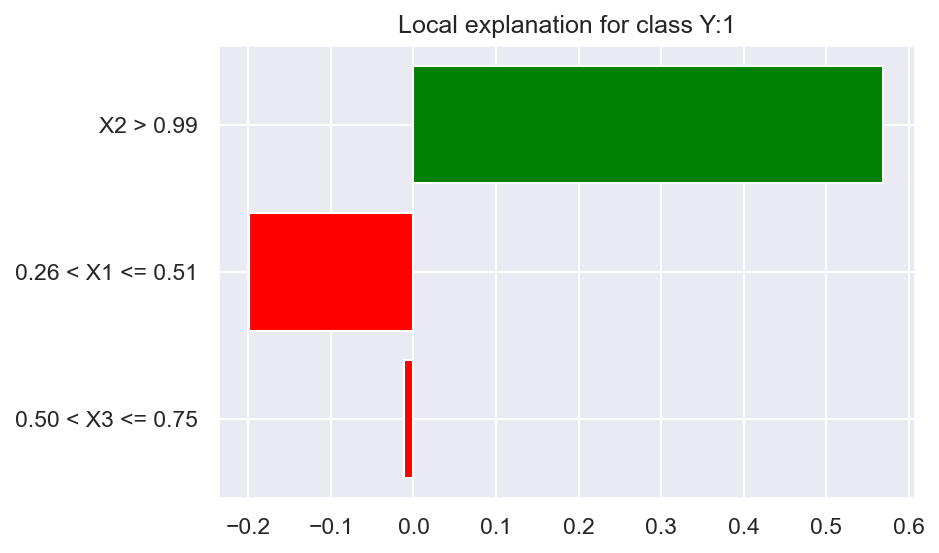

In [489]:
indx = 5

res = xgb.predict_proba([X_test[indx]])
print( "Prediction: " + str(np.argmax(res[0])) )

exp = explainer.explain_instance(X_test[indx], xgb.predict_proba, num_features=3)
fig = exp.as_pyplot_figure()

### Generating Explanations for Neural Net


In [490]:
from  lime.lime_tabular import LimeTabularExplainer
explainer_nn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_nn

In [491]:
predict_fn = lambda x:  1.0 if nn.predict(x) >= 0.5 else 0.0

157/157 [==============================] - 0s 1ms/step


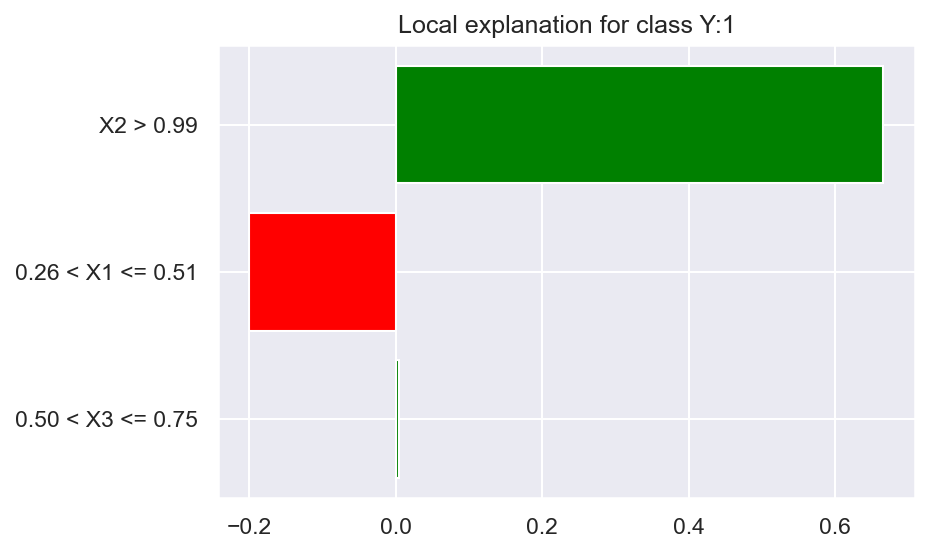

In [492]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer.explain_instance(X_test[indx], nn.predict, num_features=3)
fig = exp.as_pyplot_figure()